In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

In [2]:
from skimage.measure import find_contours
from scipy.ndimage.morphology import distance_transform_edt

In [5]:
xy_pixel_distance_lossless = 0.46

distance_accepted_um = 50.
distance_accepted_lossless = distance_accepted_um / xy_pixel_distance_lossless
distance_accepted_tb = distance_accepted_lossless / 32.

In [57]:
for stack in ['MD594', 'MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
# for stack in ['MD594']:

    print stack

    first_bs_sec, last_bs_sec = section_range_lookup[stack]
    
    dm = DataManager(stack=stack)

    for sec in range(first_bs_sec, last_bs_sec+1):

        dm.set_slice(sec)
        m = dm.load_thumbnail_mask()
        
        mp = pad(m, ((5,5), (5,5)), mode='constant')
        
        cnts = find_contours(mp, .5) # y, x
        lengths = map(len, cnts)
        cnt = cnts[np.argmax(lengths)].astype(np.int) - (5,5)
        ys = cnt[:,0]
        xs = cnt[:,1]
        cnt2 = cnt[(ys > 5) & (xs > 5) & (m.shape[1]-1-xs > 5) & (m.shape[0]-1-ys > 5)].astype(np.int)

        m2 = np.zeros_like(m)
        m2[cnt2[:,0], cnt2[:,1]] = 1

        distance_to_contour = distance_transform_edt(~m2)

        contour_prob_map = np.exp(-distance_to_contour**2/(2*distance_accepted_tb)**2)
        contour_prob_map[contour_prob_map < 1e-2] = 0

        contourMap_rootdir = create_if_not_exists('/oasis/projects/nsf/csd395/yuncong/CSHL_outerContourMap')
        contourMap_dir = create_if_not_exists(contourMap_rootdir + '/%(stack)s/%(sec)04d/' % {'stack': stack, 'sec': sec})

        img_fn = contourMap_dir + '/%(stack)s_%(sec)04d_denseScoremapThumbnail_outerContour.hdf' % {'stack': stack, 'sec': sec}

        save_hdf(contour_prob_map, img_fn)

MD594
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
3

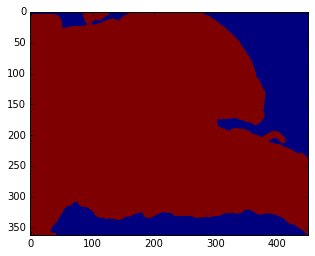

In [51]:
plt.imshow(m);

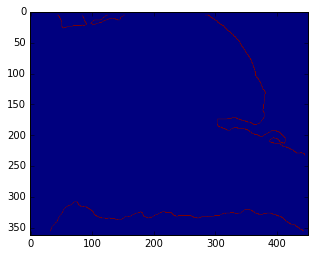

In [55]:
plt.imshow(m2);

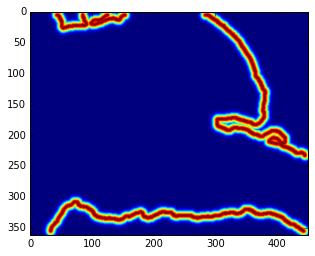

In [56]:
plt.imshow(contour_prob_map)